# Prepare Environment
### Load Libraries and dependencies

In [4]:
import cudf
cudf.__version__

'24.02.02'

In [5]:
import cuml
cuml.__version__

'24.02.00'

In [46]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import pickle

#import dask_ml.model_selection as dcv
from sklearn.model_selection import GridSearchCV
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

from sklearn import datasets
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_curve, confusion_matrix, auc
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from cuml.model_selection import train_test_split
from cuml.metrics.accuracy import accuracy_score

import time
from contextlib import contextmanager

In [1]:
import pandas
pandas.__version__

'1.5.3'

In [2]:
import sklearn
sklearn.__version__

'1.4.1.post1'

### Create Timer Function

In [ ]:
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

In [ ]:
#set global seed var
seed =40

### Silence Warning Prints

In [19]:
import warnings
warnings.filterwarnings("ignore")  # Reduce number of messages/warnings displayed

# Set GPU memory when restarting kernel

In [5]:
!nvidia-smi

Fri Apr 26 02:59:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   29C    P5              40W / 420W |   1984MiB / 24576MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
#Print GPU list
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-f95b02b8-3c1a-8104-7eb1-25ec537b65e4)
GPU 1: NVIDIA GeForce RTX 2060 SUPER (UUID: GPU-9234d598-4065-602a-8139-1b0b2bc70750)


In [9]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

CUDA available: True


In [1]:
#Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0" #select 3090

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'os' is not defined

In [11]:
#Clear GPU memory on 'kernel reset and run all'
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

2

### Spin up CUDA Cluster

In [15]:
#3090: GPU-f95b02b8-3c1a-8104-7eb1-25ec537b65e4
#2060S: GPU-9234d598-4065-602a-8139-1b0b2bc70750

cluster = LocalCUDACluster(protocol="ucx", #use ucx for inter-gpu training (RDMA, exclude cpu)
                           enable_tcp_over_ucx=None,
                           CUDA_VISIBLE_DEVICES= "0")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 39.03 GiB
Status: running,Using processes: True
Comm: ucx://127.0.0.1:49393,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 39.03 GiB
Comm: ucx://127.0.0.1:33253,Total threads: 1
Dashboard: http://127.0.0.1:42765/status,Memory: 39.03 GiB
Nanny: ucx://127.0.0.1:50409,


# Load Dataset

In [16]:
#Read Class Balanced Dataset
X_train = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/X_train_smote.parquet")
y_train = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/y_train_smote.parquet")['label']
X_test = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/X_test_smote.parquet")
y_test = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/y_test_smote.parquet")['label']

#Check Data type
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Define GridSearch and Model Parameters

In [17]:
N_FOLDS = 5 #folds for cross validation
N_ITER = 25 #iteration when executing random gridsearch

In [21]:
#Define cuML RF model
model_rf_ = cuRandomForestClassifier()


#gridsearch will use these parameter values to find the best performing model
params_rf = {
    "max_depth": np.arange(start=3, stop=15, step=2),  # Default = 6
    "max_features": [0.1, 0.50, 0.75, "auto"],  # default = 0.3
    "n_estimators": [100, 200, 500, 1000],
}

# Perform Gridsearch Hyperparameter Tuning
### Define Gridsearch GPU functions

In [22]:
#converts the y label into a float32 type. This is because some cuML models only accept this data type
def accuracy_score_wrapper(y, y_hat):
    """
    A wrapper function to convert labels to float32,
    and pass it to accuracy_score.

    Params:
    - y: The y labels that need to be converted
    - y_hat: The predictions made by the model
    """
    y = y.astype("float32")  # cuML RandomForest needs the y labels to be float32
    return accuracy_score(y, y_hat, convert_dtype=True)


accuracy_wrapper_scorer = make_scorer(accuracy_score_wrapper)
cuml_accuracy_scorer = make_scorer(accuracy_score, convert_dtype=True)


def do_HPO(model, gridsearch_params, scorer, X, y, mode="gpu-Grid", n_iter=10):
    """
    Perform HPO based on the mode specified

    mode: default gpu-Grid. The possible options are:
    1. gpu-grid: Perform GPU based GridSearchCV
    2. gpu-random: Perform GPU based RandomizedSearchCV

    n_iter: specified with Random option for number of parameter settings sampled

    Returns the best estimator and the results of the search
    """
    if mode == "gpu-grid":
        print("gpu-grid selected")
        clf = GridSearchCV(model, gridsearch_params, cv=N_FOLDS, scoring="f1", verbose=3)
    elif mode == "gpu-random":
        print("gpu-random selected")
        clf = GridSearchCV(
            model, gridsearch_params, cv=N_FOLDS, scoring="f1", n_iter=n_iter
        )

    else:
        print("Unknown Option, please choose one of [gpu-grid, gpu-random]")
        return None, None
    res = clf.fit(X, y)
    print(
        "Best clf and score {} {}\n---\n".format(res.best_estimator_, res.best_score_)
    )
    return res.best_estimator_, res


def print_acc(model, X_train, y_train, X_test, y_test, mode_str="Default"):
    """
    Trains a model on the train data provided, and prints the accuracy of the trained model.
    mode_str: User specifies what model it is to print the value
    """
    y_pred = model.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_pred, y_test.astype("float32"), convert_dtype=True)
    print("{} model accuracy: {}".format(mode_str, score))

In [23]:
#Coerce columns as necessary for cuML models
for col in X_train.columns:
    X_train[col] = X_train[col].astype("float32")
y_train = y_train.astype("int32")

for col in X_test.columns:
    X_test[col] = X_test[col].astype("float32")
y_test = y_test.astype("int32")

In [32]:
%%time
#Model training without hyperparameter tuning - trains in 1min and 38s - Default acc:  0.9995993375778198
# print(
#     "Default acc: ",
#     accuracy_score(model_rf_.fit(X_train, y_train).predict(X_test), y_test),
# )

Default acc:  0.9995993375778198
CPU times: user 1min 11s, sys: 26.9 s, total: 1min 38s
Wall time: 31 s


In [33]:
%%time
#  RF-gpu-grid time:  53034.19690
# Searched over 96 parameters
# CPU times: user 1d 11h 1min 12s, sys: 12h 1min 6s, total: 1d 23h 2min 18s
# Wall time: 14h 43min 54s

#Set to HPO to gridsearch mode
mode = "gpu-grid"

#Execute HPO with 'timed' function
with timed("RF-" + mode):
    res, results = do_HPO(
        model_rf,
        params_rf,
        cuml_accuracy_scorer,
        X_train,
        y_train,
        mode=mode,
        n_iter=N_ITER,
    )

#Report Results for best model hyperparameters
print("Searched over {} parameters".format(len(results.cv_results_["mean_test_score"])))

gpu-grid selected
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END max_depth=3, max_features=0.1, n_estimators=100;, score=0.925 total time=  17.0s
[CV 2/5] END max_depth=3, max_features=0.1, n_estimators=100;, score=0.924 total time=  17.7s
[CV 3/5] END max_depth=3, max_features=0.1, n_estimators=100;, score=0.924 total time=  18.9s
[CV 4/5] END max_depth=3, max_features=0.1, n_estimators=100;, score=0.924 total time=  17.1s
[CV 5/5] END max_depth=3, max_features=0.1, n_estimators=100;, score=0.924 total time=  17.6s
[CV 1/5] END max_depth=3, max_features=0.1, n_estimators=200;, score=0.928 total time=  33.2s
[CV 2/5] END max_depth=3, max_features=0.1, n_estimators=200;, score=0.927 total time=  30.7s
[CV 3/5] END max_depth=3, max_features=0.1, n_estimators=200;, score=0.927 total time=  32.8s
[CV 4/5] END max_depth=3, max_features=0.1, n_estimators=200;, score=0.927 total time=  33.5s
[CV 5/5] END max_depth=3, max_features=0.1, n_estimators=200;, score=0.927

2024-04-07 04:56:11,401 - distributed.worker - ERROR - Scheduler was unaware of this worker 'ucx://127.0.0.1:43029'. Shutting down.
2024-04-07 04:56:11,439 - distributed.core - INFO - Connection to ucx://127.0.0.1:43415 has been closed.


[CV 1/5] END max_depth=7, max_features=0.75, n_estimators=1000;, score=0.999 total time= 5.6min


2024-04-07 05:01:48,917 - distributed.worker - ERROR - Scheduler was unaware of this worker 'ucx://127.0.0.1:50999'. Shutting down.
2024-04-07 05:01:48,963 - distributed.core - INFO - Connection to ucx://127.0.0.1:43415 has been closed.


[CV 2/5] END max_depth=7, max_features=0.75, n_estimators=1000;, score=0.999 total time= 5.6min


2024-04-07 05:01:50,968 - distributed.nanny - ERROR - Worker process died unexpectedly


[CV 3/5] END max_depth=7, max_features=0.75, n_estimators=1000;, score=0.999 total time= 5.6min
[CV 4/5] END max_depth=7, max_features=0.75, n_estimators=1000;, score=0.999 total time= 5.6min
[CV 5/5] END max_depth=7, max_features=0.75, n_estimators=1000;, score=0.999 total time= 5.6min
[CV 1/5] END max_depth=7, max_features=auto, n_estimators=100;, score=1.000 total time=  22.0s
[CV 2/5] END max_depth=7, max_features=auto, n_estimators=100;, score=0.999 total time=  22.5s
[CV 3/5] END max_depth=7, max_features=auto, n_estimators=100;, score=0.999 total time=  22.2s
[CV 4/5] END max_depth=7, max_features=auto, n_estimators=100;, score=0.999 total time=  22.6s
[CV 5/5] END max_depth=7, max_features=auto, n_estimators=100;, score=0.999 total time=  22.1s
[CV 1/5] END max_depth=7, max_features=auto, n_estimators=200;, score=0.999 total time=  43.2s
[CV 2/5] END max_depth=7, max_features=auto, n_estimators=200;, score=0.999 total time=  44.4s
[CV 3/5] END max_depth=7, max_features=auto, n_

In [34]:
#Get improved model accuracy - Improved acc:  0.9996417164802551
# print("Improved acc: ", accuracy_score(res.predict(X_test), y_test))

Improved acc:  0.9996417164802551


In [24]:
#Tabluate gridsearch results
# rf_gridsearch_res_df = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
# rf_gridsearch_res_df.to_csv('trained_models/rf_gridsearch_res.csv', index=False)
# rf_gridsearch_res_df

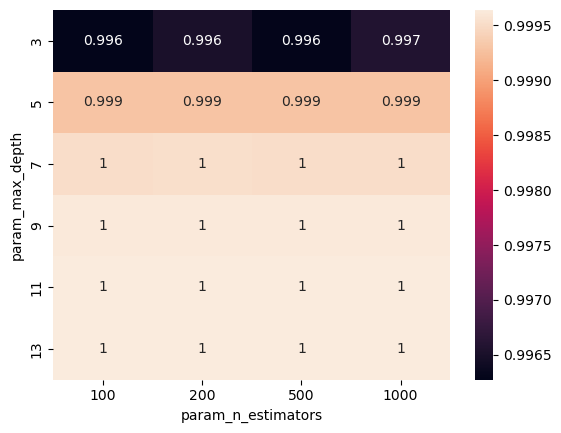

In [35]:
# from cuml.experimental.hyperopt_utils import plotting_utils
# df_gridsearch = pd.DataFrame(results.cv_results_)
# plotting_utils.plot_heatmap(df_gridsearch, "param_max_depth", "param_n_estimators")

In [36]:
#{'max_depth': 13, 'max_features': 0.5, 'n_estimators': 200}
# results.best_params_

{'max_depth': 13, 'max_features': 0.5, 'n_estimators': 200}

# Train and Test with Official Parameters

In [26]:
# best_params_rfmodel = cuRandomForestClassifier(max_depth=13, max_features=0.5, n_estimators=200)

In [27]:
%%time

#Executes in 1min and 18secs
# Fit the model to the training data
# model = best_params_rfmodel.fit(X_train, y_train)

CPU times: user 3min 18s, sys: 1min 15s, total: 4min 33s
Wall time: 1min 18s


In [28]:
%%time
#Executes in 583ms
# Make predictions on the testing data
# y_pred = model.predict(X_test)

CPU times: user 610 ms, sys: 235 ms, total: 845 ms
Wall time: 583 ms


# Evaluate Model

In [48]:
#load model if already trained
filename = '../trained_models/cuRF_model_HPO_9996accuracy.pkl'

with open(filename, 'rb') as file:
    best_params_rfmodel = pickle.load(file)
y_pred = best_params_rfmodel.predict(X_test)


In [49]:
#Calculate Scoring Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9996417164802551
Precision: 0.9996419100736285
Recall: 0.9996417191301331
F1 Score: 0.9996416920704301


### Confusion Matrix

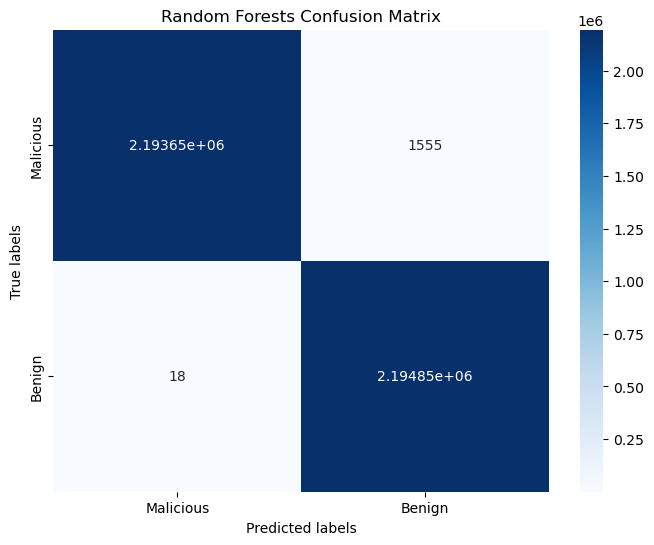

In [45]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Malicious', 'Benign'], yticklabels=['Malicious', 'Benign'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forests Confusion Matrix')
plt.savefig('../../Graphs/Conf_Mat/RF_HPO_CM_maxdepth13_maxfeatures05_nestimators200.png')
plt.show()

### ROC Curve

In [38]:
#Calculate model prediciton probabilities
y_probs = model.predict_proba(X_test)
y_probs.head()

,0,1
1705238,0.000011,0.999989
13645399,0.999999,0.000001
1483525,0.000010,0.999990
5277299,0.000011,0.999989
1209595,0.000011,0.999989


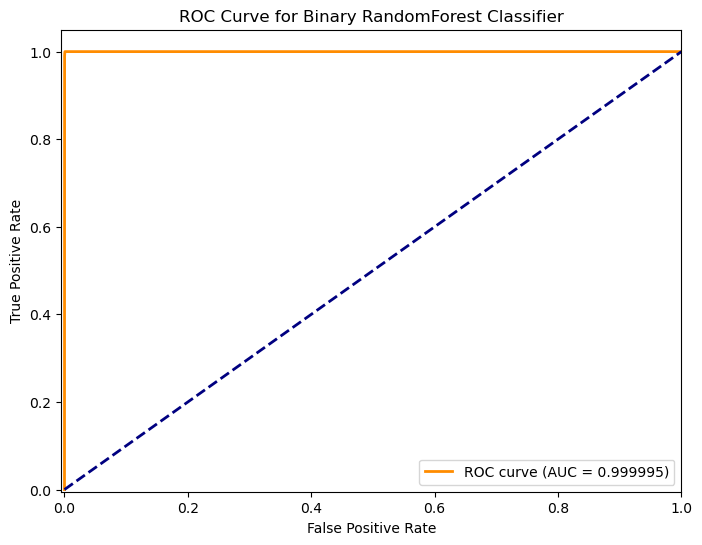

In [49]:
#Calculate prediction performance metrics
fpr, tpr, thresholds = roc_curve(y_test, y_probs[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([-0.005, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary RandomForest Classifier')
plt.legend(loc="lower right")
plt.savefig('../../Graphs/ROC_CUR/RF_HPO_ROC_maxdepth13_maxfeatures05_nestimators200.png')
plt.show()

# Saving Trained Model

In [69]:
# import pickle

# # Save the trained model using pickle
# model_filename = 'cuRF_model_HPO_9996accuracy.pkl'
# with open(model_filename, 'wb') as file:
#     pickle.dump(model, file)